In [0]:
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
blob_container = "w261-scrr" # The name of your container created in https://portal.azure.com
storage_account = "midsw261rv" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261scrr" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261scrrkey" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)
import pyspark.sql.functions as F

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import concat

import pyspark
# from pyspark.sql.functions import col, concat, lit, regexp_replace, when, length, lpad, to_timestamp, max, rank
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import airporttime
from datetime import datetime, timedelta
import pandas as pd; pd.set_option('max_columns', 6)  # Unclutter display.
import altair as alt
from vega_datasets import data

In [0]:
%run "./libs/model_helper_functions"

In [0]:
df_train_raw = spark.read.parquet(f"{blob_url}/train_agg_0404")
df_test_raw = spark.read.parquet(f"{blob_url}/test_agg_0404")

train_sampled = df_train_raw.sample(False, 0.0001, seed = 0)
test_sampled = df_test_raw.sample(False, 0.00009, seed = 0)

In [0]:
print(train_sampled.count()) #2353
print(test_sampled.count()) #652

2315
658

In [0]:
#import and clean holiday dataset
holidays = spark.read.parquet(f"{blob_url}/holidays")
for column in ["Month", "Day"]:
    holidays = holidays.withColumn(column, F.when(F.length(F.col(column))<2, F.lpad(F.col(column), 2, "0")).otherwise(F.col(column)))
holidays = holidays.withColumn("Is_Holiday", F.lit(1))
holidays = holidays.withColumn("Date", F.concat(F.col("Year"), F.lit("-"), F.col("Month"), F.lit("-"), F.col("Day")))
holidays = holidays.withColumn("Date_time", F.to_timestamp(holidays.Date, "yyyy-mm-dd"))

#join holiday column
df_train = train_sampled.join(holidays, train_sampled.FL_DATE == holidays.Date, how = 'left')
df_train = df_train.withColumn("Is_Holiday", F.col("Is_Holiday").cast(DoubleType())).fillna(0).cache()
df_test = test_sampled.join(holidays, test_sampled.FL_DATE == holidays.Date, how = 'left')
df_test = df_test.withColumn("Is_Holiday", F.col("Is_Holiday").cast(DoubleType())).fillna(0).cache()

In [0]:
#select features
cols = ["Is_Holiday", "PREV_DEP_DEL15", 'DEP_DEL15']
feature_cols = ["Is_Holiday", "PREV_DEP_DEL15"]
train_sampled = df_train.select(*cols)
test_sampled = df_test.select(*cols)
train_sampled.limit(5).show()
#convert to rdd format
train_sampled = train_sampled.select(F.array("Is_Holiday", "PREV_DEP_DEL15").alias("features"), 'DEP_DEL15')
test_sampled = test_sampled.select(F.array("Is_Holiday", "PREV_DEP_DEL15").alias("features"), 'DEP_DEL15')

train_rdd = train_sampled.rdd.cache()
test_rdd = test_sampled.rdd.cache()

+----------+--------------+---------+
Is_Holiday|PREV_DEP_DEL15|DEP_DEL15|
+----------+--------------+---------+
 0.0| 0.0| 0.0|
 0.0| 0.0| 0.0|
 0.0| 0.0| 0.0|
 0.0| 0.0| 0.0|
 0.0| 0.0| 0.0|
+----------+--------------+---------+

In [0]:
def LogisticLoss(dataRDD, W):
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    loss = augmentedData.map(lambda x: (-x[1] * (np.log(1 / (1 + np.exp(-x[0].dot(W))) + 1e-5))\
                            -((1-x[1]) * (np.log(1 - (1 / (1 + np.exp(-x[0].dot(W)))) + 1e-5))))).mean()
    return loss

def GDUpdate(dataRDD, W, learningRate = 0.3):
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    grad = augmentedData.map(lambda x: (1 / (1 + np.exp(-x[0].dot(W))) - x[1]) * x[0]).mean()
    new_model = W - learningRate*grad
    return new_model

def GradientDescent(trainRDD, testRDD, wInit, nSteps = 40, 
                    learningRate = 0.1):
    train_history, test_history, model_history = [], [], []
    model = wInit
    for idx in range(nSteps): 
        model = GDUpdate(trainRDD, model, learningRate = learningRate)
        training_loss = LogisticLoss(trainRDD, model)
        test_loss = LogisticLoss(testRDD, model)
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
    return train_history, test_history, model_history

def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Cost')
    if title:
        plt.title(title)
    plt.show()
    
def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    # augmented data
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    new_model = None
    #################### YOUR CODE HERE ###################
    if regType == 'ridge':
        grad = 2*augmentedData.map(lambda x: (np.dot(W,x[0])-x[1])*x[0]).mean() + 2*regParam*np.append([0.0], W[1:])
    elif regType == 'lasso':
        W_sign = np.sign(np.append([0.0], W[1:]))
        grad = 2*augmentedData.map(lambda x: (np.dot(W,x[0]) - x[1])*x[0]).mean() + regParam*W_sign
        
    elif regType == 'lasso':
        grad = augmentedData.map(lambda x: 2*(np.array(W).dot(x[0])-x[1])*x[0]).mean() + regParam*np.sign(np.append([0.0], W[1:]))
    else:
        grad = 2*augmentedData.map(lambda x: (np.dot((np.dot(W,x[0]) - x[1]),x[0]))).mean()
    
    new_model = W - learningRate*grad
    
    ################## (END) YOUR CODE ####################
    return new_model

[0.7634663271340257, 0.7496202778851502, 0.7364570201076057, 0.7239443229618704, 0.7120509449972374, 0.7007466898505998, 0.6900024465986716, 0.6797902164371198, 0.670083127322978, 0.6608554381490747, 0.6520825339294107, 0.6437409133695403, 0.6358081700822025, 0.628262968590532, 0.6210850161431724, 0.6142550312504416, 0.6077547097406243, 0.6015666890319985, 0.5956745112203268, 0.5900625854937952, 0.584716150307947, 0.5796212356819445, 0.5747646259142142, 0.5701338229598014, 0.5657170106630205, 0.5615030199967329, 0.5574812954232027, 0.5536418624603909, 0.5499752965112169, 0.5464726929911592, 0.5431256387711226, 0.5399261849372792, 0.5368668208571733, 0.533940449531403, 0.5311403642022678, 0.5284602261846439, 0.5258940438797222, 0.5234361529288737, 0.5210811974626096, 0.5188241123981812]

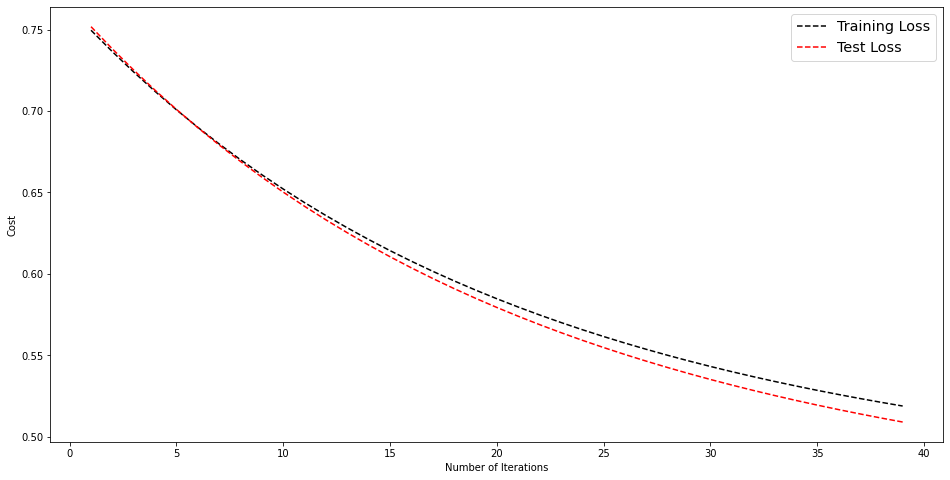

In [0]:
wInit = np.array([.24] + [0]*2)
train_history, test_history, model_history = GradientDescent(train_rdd, test_rdd, wInit)
print(train_history)
plotErrorCurves(train_history, test_history)

In [0]:
# def predict(X, params):
#     return np.round(sigmoid(X @ params))

# y_pred = predict(X, params_optimal)
# score = float(sum(y_pred == y))/ float(len(y))

# print(score)